# Aula-04 Análise de Sentimentos usando Bag of Embeddings
Nome: Thomás Portugal

Neste colab iremos treinar um modelo para fazer análise de sentimento usando o dataset IMDB.

In [258]:
import torch
import pandas as pd
import numpy as np
from torchtext.vocab import GloVe

from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm_notebook
from math import ceil
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer

if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu" 
print(dev)
device = torch.device(dev)

cpu


# Preparando Dados

Primeiro, fazemos download do dataset:

In [259]:
!wget -nc http://files.fast.ai/data/examples/imdb_sample.tgz
!tar -xzf imdb_sample.tgz

File ‘imdb_sample.tgz’ already there; not retrieving.



Carregamos o dataset .csv usando o pandas:

In [260]:
df = pd.read_csv('imdb_sample/texts.csv')
df.shape
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


Iremos agora dividir o dataset em conjuntos de treino e desenvolmento:

In [261]:
treino = df[df['is_valid'] == False]
valid = df[df['is_valid'] == True]

print('treino.shape:', treino.shape)
print('valid.shape:', valid.shape)

treino.shape: (800, 3)
valid.shape: (200, 3)


E iremos dividir estes dois conjuntos em entrada (X) e saída desejada (Y, ground-truth) do modelo:

In [262]:
X_treino = treino['text']
Y_treino = treino['label']
X_valid = valid['text']
Y_valid = valid['label']

print('X_treino.head():', X_treino.head())
print('Y_treino.head():', Y_treino.head())

X_treino.head(): 0    Un-bleeping-believable! Meg Ryan doesn't even ...
1    This is a extremely well-made film. The acting...
2    Every once in a long while a movie will come a...
3    Name just says it all. I watched this movie wi...
4    This movie succeeds at being one of the most u...
Name: text, dtype: object
Y_treino.head(): 0    negative
1    positive
2    negative
3    positive
4    negative
Name: label, dtype: object


Ainda falta converter as strings "positive" e "negative" do ground-truth para valores booleanos:

In [263]:
mapeamento = {'positive': True, 'negative': False}
Y_treino_bool = Y_treino.map(mapeamento)
Y_valid_bool = Y_valid.map(mapeamento)
print(Y_treino_bool.head())

0    False
1     True
2    False
3     True
4    False
Name: label, dtype: bool


# Carregando word embeddings com torchtext

Alternativamente, podemos carregar os word embeddings (mais especificamente, o glove) usando o torchtext.

Obrigado Paulo e Leard por terem sugerido essa opção.

In [264]:
!wget -nc http://nlp.stanford.edu/data/glove.6B.zip
!unzip -o glove.6B.zip -d glove_dir

--2020-04-02 01:51:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-04-02 01:51:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-04-02 01:51:12--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
from torchtext.vocab import GloVe
glove_vectors = GloVe(name='6B', dim=300, cache='./glove_dir')

In [266]:

print(glove_vectors.stoi['of'])
print(glove_vectors.vectors.shape)
print('Primeiras 20 palavras e seus índices:', list(glove_vectors.stoi.items())[:20])

3
torch.Size([400000, 300])
Primeiras 20 palavras e seus índices: [('the', 0), (',', 1), ('.', 2), ('of', 3), ('to', 4), ('and', 5), ('in', 6), ('a', 7), ('"', 8), ("'s", 9), ('for', 10), ('-', 11), ('that', 12), ('on', 13), ('is', 14), ('was', 15), ('said', 16), ('with', 17), ('he', 18), ('as', 19)]


In [0]:
token_dict = glove_vectors.stoi
vectors_embbed = glove_vectors.vectors


## Usando TF-IDF para análise de sentimentos

In [268]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm_notebook
from math import ceil
from matplotlib import pyplot as plt
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cpu


In [279]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_treino)
X_test_tfidf = vectorizer.transform(X_valid)
vocab_size = len(vectorizer.vocabulary_)
vocab_size

16461

In [0]:
X_train_tfidf = torch.tensor(X_train_tfidf.toarray(), dtype = torch.float)
X_test_tfidf = torch.tensor(X_test_tfidf.toarray(), dtype = torch.float)
Y_train = torch.tensor(Y_treino_bool.values, dtype = torch.long)
Y_test = torch.tensor(Y_valid_bool.values, dtype = torch.long)

## Criação do modelo:
Mesma configuração do modelo usado nos dados com bag of words:
  * 3 Camadas: (16461 x 1000 x 500 x 50 x 2)
  * Função de ativação: ReLU


In [0]:
class Model_TFIDF(torch.nn.Module):
  def __init__(self, vocab_size):
    super(Model_TFIDF,self).__init__()
    self.layer1 = torch.nn.Linear(in_features=vocab_size, out_features= 1000)
    self.layer2 = torch.nn.Linear(in_features=1000, out_features= 500)
    self.layer3 = torch.nn.Linear(in_features = 500, out_features= 50)
    self.layer4 = torch.nn.Linear(in_features= 50, out_features=2)
    self.activation = torch.nn.ReLU()
    self.log_softmax = torch.nn.LogSoftmax() 
  
  def forward(self, x):
    x = x.to(device)
    x = self.layer1(x)
    x = self.activation(x)
    x = self.layer2(x)
    x = self.activation(x)
    x = self.layer3(x)
    x = self.activation(x)
    x = self.layer4(x)
    return x

In [0]:
def create_batch(X,Y,batch_size, type = 'tfidf'):
  mini_batches_X = []
  mini_batches_Y = []
  n_batches = ceil(X.shape[0]/batch_size)
  start = 0
  end = batch_size
  if type == 'tfidf':
    for n in range(n_batches):
      mini_batches_X.append(X[start:end,:])
      mini_batches_Y.append(Y[start:end])
      start += batch_size
      end +=batch_size if start+batch_size<X.shape[0]+1 else X.shape[0] % batch_size
  else:
    for n in range(n_batches):
      mini_batches_X.append(X[start:end])
      mini_batches_Y.append(Y[start:end])
      start += batch_size
      end += batch_size if start+batch_size<X.shape[0]+1 else X.shape[0] % batch_size
  
  return mini_batches_X, mini_batches_Y
    

In [0]:
def train(X, Y, batch_size, model, n_epochs, optimizer,type = 'tfidf', loss_function = torch.nn.CrossEntropyLoss(), validate = False, X_val = None, Y_val = None):
  train_loss_list = []
  
  progress = tqdm_notebook(total=n_epochs)
  model = model.to(device)
  for epoch in range(n_epochs):
    model.train()
    running_loss= 0.0
    batches_X, batches_Y = create_batch(X,Y,batch_size, type = type)
    for index, batch in enumerate(batches_X):
      y_logits = model(batch)
      loss = loss_function(y_logits,batches_Y[index].to(device))
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      running_loss += loss.item()
    progress.update(1)
    train_loss_list.append(running_loss/len(batches_X))
    
  return train_loss_list

def test(X, Y, model,batch_size,type ='tfidf', loss_function=torch.nn.CrossEntropyLoss()):
  batches_X, batches_Y = create_batch(X,Y,batch_size, type = type)
  running_loss = 0
  sum_correct = 0
  model.eval()
  with torch.no_grad():
    for index, batch in enumerate(batches_X):
      y_logits = model(batch)
      loss = loss_function(y_logits,batches_Y[index].to(device))
      running_loss += loss.item()
      y_prob = torch.nn.functional.log_softmax(y_logits)
      y_pred = y_prob.argmax(dim=1)
      sum_correct = torch.eq(batches_Y[index],y_pred).sum().item()
      # print("Running Loss Test: {}".format(running_loss))
    test_loss = running_loss/len(batches_X)
    acc = sum_correct/len(Y)
    
    print("Loss: {:.4f} Accuracy: {:.4f}".format(test_loss, acc))
  return test_loss, acc


In [274]:
batch_size = 200
n_epochs = 1000
model_tfidf = Model_TFIDF(vocab_size = vocab_size)
optimizer = torch.optim.SGD(model_tfidf.parameters(), lr = 0.1)
train_loss_list = train(X_train_tfidf,Y_train,batch_size,model_tfidf,n_epochs,optimizer)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'N_epochs x Loss - Train Set')

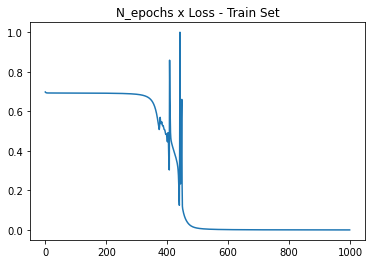

In [275]:
plt.plot(train_loss_list)
plt.title("N_epochs x Loss - Train Set")

In [281]:
sum([torch.tensor(x.size()).prod() for x in model_tfidf.parameters()])

tensor(16987652)

In [286]:
loss_test, acc = test(X_test_tfidf,Y_test,model_tfidf,200)

Loss: 0.7432 Accuracy: 0.8050


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Modelo Word Embedding:
Utilizando o vocabulário GLove com 400.000 palavras e dimensão do embedding igual a 400. 



In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
vocab_glove = glove_vectors.stoi
vectors_embedded = glove_vectors.vectors
vocab_size = len(vocab_glove)

In [0]:
vectorizer_cv = CountVectorizer().fit(X_treino)
vocab_cv = vectorizer_cv.vocabulary_
tokenizer = vectorizer_cv.build_tokenizer()
tst = tokenizer(X_treino[0])
# token_cv2glove = {}

In [0]:
class Model_Word2Vec(torch.nn.Module):
  def __init__(self, vocab, vocab_size, word2vec, hidden_size = 1000, embedding_dim = 300):
    super(Model_Word2Vec,self).__init__()

    self.vocab = vocab
    self.word2vec = word2vec

    self.embedding_bag = torch.nn.EmbeddingBag(vocab_size,embedding_dim)
    self.embedding_bag.weight = torch.nn.Parameter(word2vec)
    self.embedding_bag.weight.requires_grad = False
    self.layer1 = torch.nn.Linear(in_features = embedding_dim , out_features=hidden_size)
    self.activation = torch.nn.ReLU()
    self.layer2 = torch.nn.Linear(in_features = hidden_size, out_features = 2)
    self.sotfmax = torch.nn.LogSoftmax()  
    
  def forward(self,x):
    
    embedding, offset = calc_embedding_bag(x, self.word2vec, self.vocab)
    embedding = embedding.to(device)
    # print(offset.shape)
    x = self.embedding_bag(embedding,offset)
    # print(x.shape)
    x = self.layer1(x)
    x = self.activation(x)
    x = self.layer2(x)
    return x

Função que tokeniza o corpus usando o vocabulario do Glove e calcula os offsets para serem colocados na entrada da rede.

In [0]:
def calc_embedding_bag(corpus,word2vec, vocab):
  offsets = []
  count_w = -1
  batch_tokens = []  
  count_error = 0
  if type(corpus) == str:
    corpus = list([corpus])
  for sentence in corpus:

    offsets.append(count_w+1)
    sentence = tokenizer(sentence)
    size_sentence = len(sentence)
    
    for word in sentence:
      
      try:
        token = vocab[word.lower()]
        batch_tokens.append(token)
        count_w +=1
        # print("Encontrada:{}".format(word))
      except:
        count_error += 1
  
  word_vectors = torch.tensor(batch_tokens, dtype = torch.long)
  offsets = torch.tensor(offsets, dtype = torch.long)
  return word_vectors, offsets

Teste do calculo de bag embedding

In [294]:
sample = X_treino.values[0:5]
a = 0
embeddings, offset = calc_embedding_bag(sample, vectors_embbed, token_dict)
bag = torch.nn.EmbeddingBag(vocab_size, 300)
bag(embeddings,offset).shape

torch.Size([5, 300])

Teste com o modelo com um sample

In [295]:
model = Model_Word2Vec(vocab_glove,vocab_size,vectors_embedded)
model(sample[0]).shape

torch.Size([1, 2])

## Training the model with glove.
 * 1 Camada oculta com 1000 neurônios
 * 3000 épocas
 * Batch size = 200
 * LR = 0.01


In [297]:
batch_size = 200
n_epochs = 3000
hidden_size = 1000
model_glove = Model_Word2Vec(vocab_glove,vocab_size,vectors_embedded, hidden_size = hidden_size)
optimizer = torch.optim.SGD(model_glove.parameters(), lr = 0.01)
train_loss_list = train(X_treino.values,Y_train,batch_size,model_glove,n_epochs,optimizer, type='word2vec')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'N_epochs x Loss - Train Set')

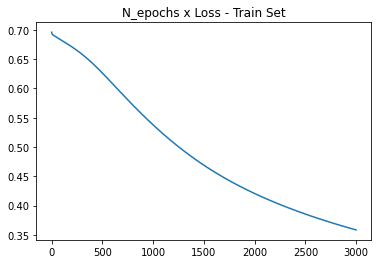

In [298]:
plt.plot(train_loss_list)
plt.title("N_epochs x Loss - Train Set")

In [299]:
test(X_valid.values,Y_test,model_glove,batch_size,type='word2vec')

Loss: 0.4582 Accuracy: 0.8150


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


(0.45819640159606934, 0.815)

In [301]:
sum([torch.tensor(x.size()).prod() for x in model_glove.parameters()])

tensor(120303002)

In [303]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

303002